In [2]:
import pysal
import numpy as np
#from pysal import spreg
import libpysal
import esda
from pysal.model import spreg
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import contextily as ctx
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

# <img style="float: left; padding: 0px 10px 0px 0px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/1920px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png"  width="80" /> MCD3100 - Ciencia de Datos Geoespaciales
**Pontificia Universidad Católica de Chile**<br>
**Magister en Ciencia de Datos**<br>

## Tutorial N°11: Regresión Espacial

Este Notebook está basado en el capítulo [Spatial Regression](https://geographicdata.science/book/notebooks/11_regression.html) del libro *Geographic Data Science with Python* (Rey, Arribas-Bel & Wolf). En este código, se replica el ejemplo desarrollado en el libro sobre modelamiento espacial del precio de propiedades en la ciudad de San Diego, California, en base a data de la plataforma de arriendos temporales AirBnB. 

Los objetivos son:
- Identificar las posibles falencias de modelos de regresión lineal estándar, cuando hay una estructura espacial que se refleja en la distribución de residuos.
- Conocer e implementar distitnos enfoques y alternativas de regresión espacial.
- Analizar y comparar los resultados de distintos modelos de regresión espacial.

### Datos: Base de propiedades publicados en AirBnB en la ciudad de San Diego, California.

Los datos para este tutorial, contenidos en el archivo `regression_db.geojson` fueron construidos en base a la información disponible en la plataforma [Inside AirBnB](https://insideairbnb.com/explore/), que recolecta y disponibiliza data de esta plataforma para muchas ciudades del mundo.


In [3]:
#Leemos el archivo
dat=gpd.read_file('regression_db.geojson')
dat.head()

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.9311)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.2187 32.74202)


#### Graficamos los datos:

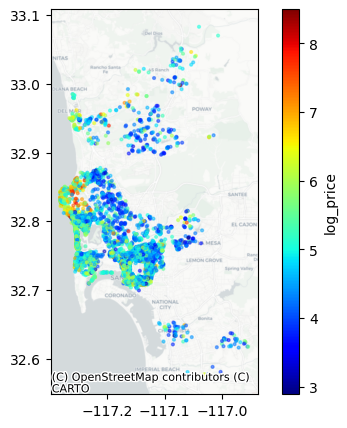

In [4]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="7%", pad="2%")

dat.plot(ax=ax,column='log_price',legend=True,markersize=4,cax=cax,alpha=0.5,legend_kwds={'label': 'log_price'},cmap='jet');
ctx.add_basemap(ax, crs=dat.crs,source=ctx.providers.CartoDB.Positron)
cax.set_label('log_price');



## 1.Regresión no-espacial.

#### Objetivo:
Explicar la variación en una variable *dependiente*, como una función lineal de una colección de variables *independientes* o *explicativas*. En este caso, la variable dependendiente es el **logaritmo del precio de arriendo de las propiedades**,`log_price`. 

#### Ejemplo:
Explicar el precio de una casa como una función del nº de habitaciones, n° de baños y camas, y otras características.

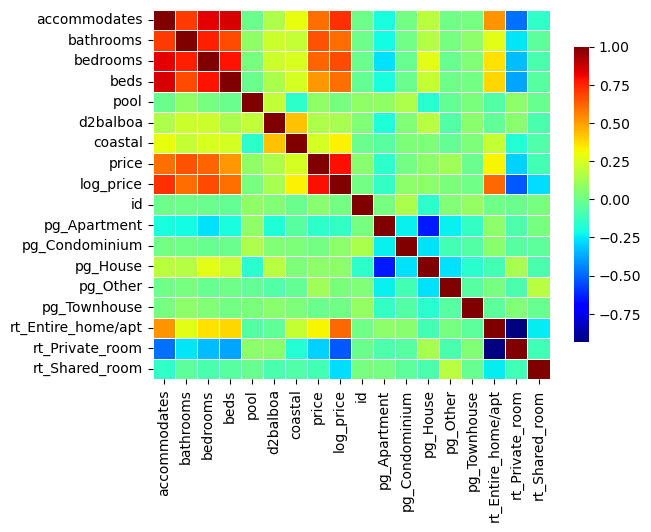

In [5]:
corr = dat.corr(numeric_only=True)
sns.heatmap(corr, square=False, linewidths=.5, cbar_kws={"shrink": .8},cmap='jet');

In [6]:
#Seleccionamos las variables independientes a usar en el modelo. 
#Ud. puede cambiar la lista de variables.

x_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Entire_home/apt",
    #"rt_Private_room",  # Room type: private room
    #"rt_Shared_room",  # Room type: shared room
    #"pg_Condominium",  # Property group: condo
    #"pg_House",  # Property group: house
    #"pg_Other",  # Property group: other
    #"pg_Townhouse"
]

In [7]:
# Creación de matrices y,X
y = dat['log_price'].values
y.shape = (len(y),1)
X= dat[x_names].values

#### Ajuste de la regresión lineal no-espacial.

Para calcular el ajuste lineal a los datos, utilizaremos la función OLS (ordinary leasts squares) del módulo de análisis espacial `spreg`de `pysal`. Esta función extiende las posibilidad de la función OLS de `statsmodel` para facilitar la incorporación de efectos espaciales en el modelo.

Puede revisar la documentación acá: https://spreg.readthedocs.io/en/latest/generated/spreg.OLS.html

In [33]:
#Ajuste lineal de mínimos cuadrados ordinarios (OLS)

ls = spreg.ols.OLS(y, X, name_y = 'log_price', name_x = x_names)
print(ls.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :           6
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6104
R-squared           :      0.6474
Adjusted R-squared  :      0.6471
Sum squared residual:     1403.39                F-statistic           :   2241.7893
Sigma-square        :       0.230                Prob(F-statistic)     :           0
S.E. of regression  :       0.479                Log likelihood        :   -4175.703
Sigma-square ML     :       0.230                Akaike info criterion :    8363.406
S.E of regression ML:      0.4793                Schwarz criterion     :    8403.712

------------------------------------------------------------

In [34]:
beta=ls.betas #coeficientes
beta.T

array([[ 3.79706092,  0.09417285,  0.1909857 ,  0.14479683, -0.05630316,
         0.61310761]])

In [35]:
#Predicciones y residuos para y
dat['logprice_pred_OLS']=ls.predy
dat['res_OLS']=ls.u #(real-pred)
dat.head()

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,...,rt_Shared_room,geometry,logprice_pred_OLS,res_OLS,quadrant,significant,quad_class,res_fe,slag_pg_Condominium,res_exog
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,...,0,POINT (-117.12971 32.75399),5.439991,0.612098,4,False,HL,0.800662,0.0,0.660152
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,...,0,POINT (-117.25253 32.78421),5.230572,0.092438,1,False,HH,-0.002525,0.2,-0.035135
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,...,0,POINT (-117.14121 32.75327),4.264886,0.330234,1,False,HH,0.417416,0.1,0.276866
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,...,0,POINT (-117.15269 32.9311),4.264886,0.011780,4,False,HL,0.312060,0.0,-0.007849
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,...,0,POINT (-117.2187 32.74202),4.264886,-0.257553,3,False,LL,-0.333751,0.0,-0.277182


Este modelo en general funciona bien, logrando predecir ~64% (2/3) de la variación en el precio usando las variables explicativas definidas arriba.
Pero, puede haber cierta aglomeración espacial en los errores, lo cual contradice las suposiciones del modelo lineal original.

#### ¿Hay estructura espacial en los residuos?

Por ejemplo, ¿el modelo falla más al predecir los precios de propiedades cerca o lejos de la costa?

In [11]:
def make_plot(dat,ax,column):
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="7%", pad="2%")

    dat.plot(ax=ax,column=column,legend=True,markersize=4,cax=cax,alpha=0.5,cmap='jet',legend_kwds={'label': column},);
    ctx.add_basemap(ax, crs=dat.crs,source=ctx.providers.CartoDB.Positron)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

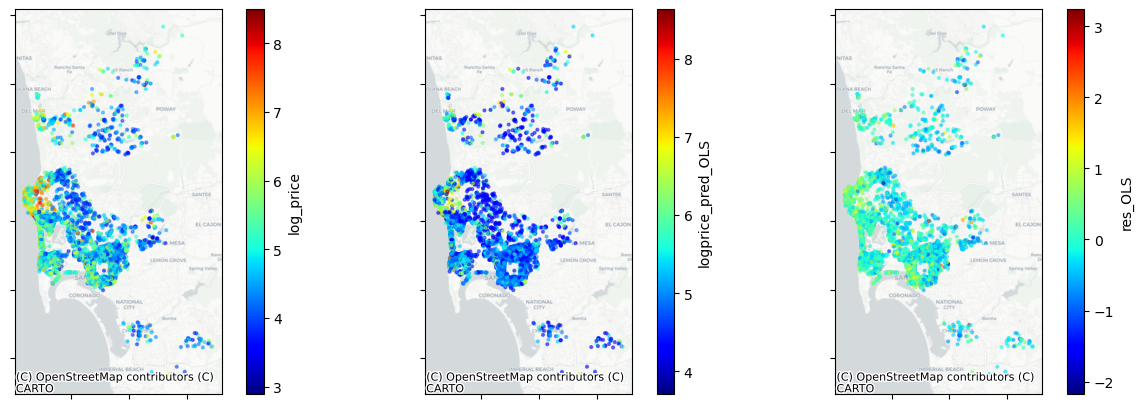

In [12]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(figsize=(15,5),nrows=1,ncols=3)

make_plot(dat,axes[0],column='log_price')
make_plot(dat,axes[1],column='logprice_pred_OLS')
make_plot(dat,axes[2],column='res_OLS')

,res_OLS
coastal,
0,-0.064925
1,0.107400


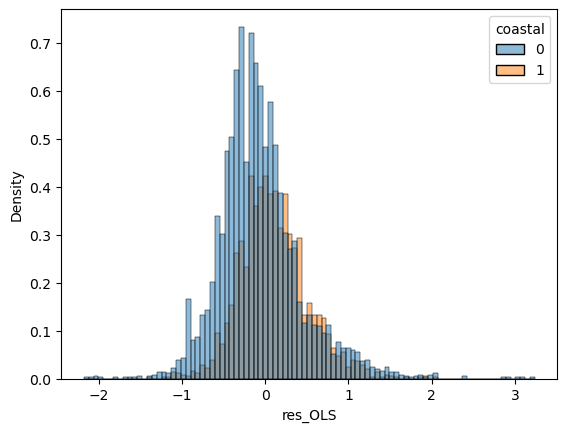

In [13]:
sns.histplot(data=dat,x='res_OLS',hue='coastal',stat='density');
pd.pivot_table(dat,index='coastal',values='res_OLS',aggfunc='mean')

Los residuos son en promedio más altos en las zonas cercanas a la costa. Es decir, el modelo aparentemente sub-estima los precioes cerca de la costa, y sobre-estima el valor de las propiedades en los barrios alejados de la costa.

#### Más aún,  ¿hay diferencias en los residuos dependiendo del vecindario?

Por ejemplo, debido a preferencias no modeladas, marketing, penalidades asociadas a variables no consideradas (contaminación, ruido, etc).

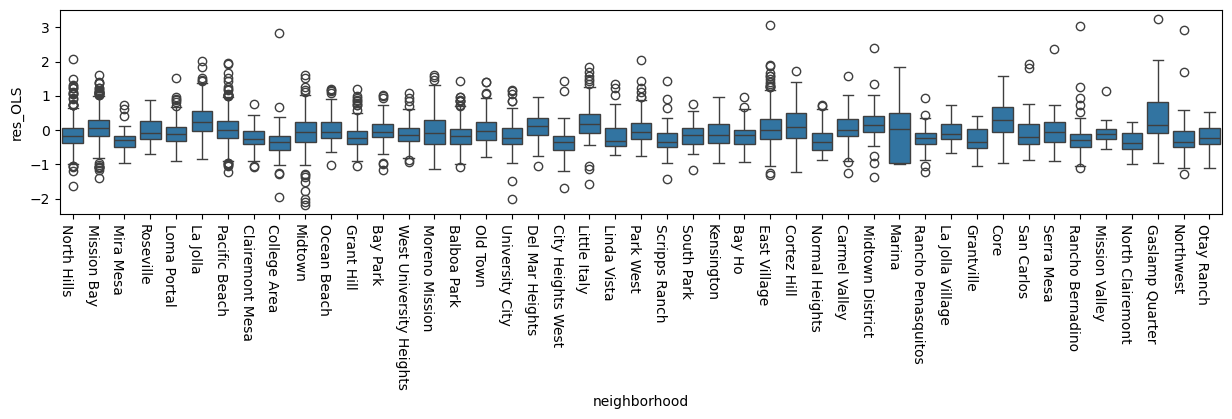

In [36]:
#crear figura y eje
f = plt.figure(figsize=(15, 3))
ax = plt.gca()

sns.boxplot(y="res_OLS",x="neighborhood",ax=ax,data=dat)
f.autofmt_xdate(rotation=-90);

### Analicemos ahora el nivel de autocorrelación en los residuos utilizando el índice de Moran: para ello, debemos definir una matriz de pesos espaciales.



In [37]:
#Para analizar el nivel de autocorrelación en los errores, necesitamos definir una matriz de pesos espaciales.
from libpysal import weights
import esda
w=weights.KNN.from_dataframe(dat,k=10) #cada propiedad, se compara con los 10 anuncios más cercanos
w.transform='R'

In [38]:
#Calculamos los indicadores locales de autocorrelación espacial (LISA)

lisa_OLS = esda.moran.Moran_Local(dat['res_OLS'], w, permutations=999)

In [39]:
#generamos una función para graficar los hot-spots y cold-spots

def plotLISA(dat,lisa,ax=None):
    dat['quadrant'] = lisa.q  #cuadrantes del grafico de Moran
    dat['significant'] = lisa.p_sim <= 0.001 #significancia estadística

    quads={1:'HH',2:'LH',3:'LL',4:'HL'}

    palette = {1:'red',2:'#83cef4',3: 'blue',4:'#e59696'}
               
    dat['quad_class'] = [quads[x] for x in dat['quadrant']]

    if ax ==None:
        fig=plt.figure(figsize=(5,5))
        ax=fig.add_subplot(111)
    
    for q in [1,3]:
        qs=dat[(dat['significant']) & (dat['quadrant']==q)] #graficamos las observaciones que caen en los cuadrantes LL y HH, con significancia del 99.9% (p_sim<0.001)
       
        if len(qs)>0:
            qs.plot(ax=ax,color=palette[q],label=quads[q],markersize=2);
            
    ax.legend()
    ax.set_xlim(-117.3,-117.0)
    ax.set_ylim(32.55,33.1);
    ctx.add_basemap(ax, crs=dat.crs,source=ctx.providers.CartoDB.Positron);


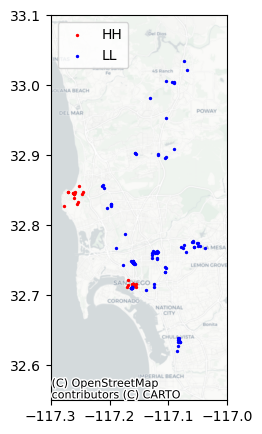

In [40]:
#LISA para el modelo OLS
plotLISA(dat,lisa_OLS)

Conclusión: el modelo de regresión simple OLS, sin efectos espaciales, tiende a sobreestimar `log_price`en la zona costera, y a subestimar en las zonas alejadas de la costa.

## 2. Heterogeneidad espacial.

El modelo puede cambiar significativamente de acuerdo a la geografía. Por ejemplo, algunas áreas pueden ser sistemáticamente más caras que otros, independiente de las características de las propiedades.

La heterogeneidad espacial puede reflejarse en cambios en el valor de el intercepto $\alpha$ (distintos valor base entre áreas geográficas) o en los valores de los coeficientes $\beta$ (distinta relación entre las variables dependientes e independientes a traés del espacio).

Para implementar modelos con heterogeneidad espacial, utilzaremos la función [spreg.OLS_Regimes](https://spreg.readthedocs.io/en/latest/generated/spreg.OLS_Regimes.html). Reivse cuidadosamente los parámetros de esta función.

### 2.1 Efectos espaciales fijos: consideremos un modelo distinto para cada zonas (coastal/not coastal)

Al incluir efectos espaciales fijos, permitimos que la constante de la regresión lineal sea distinta para cada zona. Los coeficientes $\beta$ son comunes para todas las regiones.

$Y_r=\alpha_r +\beta X$


In [19]:
# spreg spatial fixed effect implementation
m_fe = spreg.OLS_Regimes(y=dat[["log_price"]].values,  # Variable dependiente
                         x=dat[x_names].values,# Variables independientes
  
                        regimes=dat["neighborhood"].to_list(), # Variable que identifica el barrio

                        constant_regi="many",# Allow the constant term to vary by group/regime
                    
                        regime_err_sep=False, # Permitir que los coeficientes beta cambien para cada variables (regímenes espaciales)
                        cols2regi=[False] * len(x_names),# Variables dependientes cuyos coeficientes beta pueden variar (True) o que son iguales para todos los barrios

                         
                        name_y="log_price",# Dependent variable name
                        name_x=x_names,# Independent variables names
                        )


In [20]:
print(m_fe.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          50
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6060
R-squared           :      0.6893
Adjusted R-squared  :      0.6868
Sum squared residual:     1236.88                F-statistic           :    274.3278
Sigma-square        :       0.204                Prob(F-statistic)     :           0
S.E. of regression  :       0.452                Log likelihood        :   -3789.856
Sigma-square ML     :       0.202                Akaike info criterion :    7679.712
S.E of regression ML:      0.4499                Schwarz criterion     :    8015.596

----------------------------------------

In [21]:
dat['res_fe']=m_fe.u #(real-pred)
lisa_fe= esda.moran.Moran_Local(dat['res_fe'], w, permutations=999)
#plotLISA(dat,lisa_fe)

### 2.2 Regímenes espaciales

Ahora variamos no sólo la constante, sino que también los coeficientes beta para cada región $r$:

$Y_r=\alpha_r +\beta_{1r} X_1 + \beta_{2r} X_2+... \beta_{nr} X_n$



En este caso consideraremos un modelo para los barrios costeros (`coastal=1`), y otro para los barrios lejanos a la costa (`coastal=0`)



In [22]:
# spreg spatial fixed effect implementation
m_sreg = spreg.OLS_Regimes(

    # Variable dependiente
    dat[["log_price"]].values,

    # Variables independientes
    dat[x_names].values,

    # Variable que identifica el barrio
    dat["coastal"].tolist(),

    # Allow the constant term to vary by group/regime
    constant_regi="many",
    regime_err_sep=True,

    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=x_names,
)
print(m_sreg.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME 0
---------------------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  : 0_log_price                Number of Observations:        3808
Mean dependent var  :      4.7871                Number of Variables   :           6
S.D. dependent var  :      0.7376                Degrees of Freedom    :        3802
R-squared           :      0.5369
Adjusted R-squared  :      0.5363
Sum squared residual:     959.191                F-statistic           :    881.7250
Sigma-square        :       0.252                Prob(F-statistic)     :           0
S.E. of regression  :       0.502                Log likelihood        :   -2778.141
Sigma-square ML     :       0.252                Akaike info criterion :    5568.281
S.E of regression ML:      0.5019                Schwarz criterion     :    5605.751

----------------

## 3. Dependencia Espacial.

### 3.1 Efectos exógenos.

Ahora incluimos en el modelo el lag espacial de alguna(s) de las variable(s) independientes.

$Y=\beta X + \gamma W X+ \epsilon=\beta X + \gamma X_{lag}$



In [ ]:
dat.columns

Por ejemplo, ¿cuál es el efecto de que una propiedad esté en una zona de condominios?

In [24]:
from libpysal import weights

for var in ['pg_Condominium']:
    wx=weights.spatial_lag.lag_spatial(w,dat[var])
    dat['slag_%s'%var]=wx

In [25]:
# Nombres de variables
x_names_exog=['accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'rt_Private_room',
 'rt_Shared_room',
 'pg_Condominium',
 'slag_pg_Condominium']

In [26]:
# Fit linear model with `spreg`
m_exog= spreg.OLS(
    y,
    dat[x_names_exog].values,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=x_names_exog)


In [27]:
dat['res_exog']=m_exog.u
lisa_exog= esda.moran.Moran_Local(dat['res_exog'], w, permutations=999)
#plotLISA(dat,lisa_exog)
#print(m_exog.summary)

### 3.2 Efectos endógenos.

En este modelo, se considera el efecto del **lag espacial de la variable ojetivo**, como una variable explicativa adicional.

$Y=\beta X + \gamma W Y+ \epsilon=\beta X + \gamma Y_{lag}$

Esto se puede interpretar como un efecto de "decisión conjunta": uno de los efectos que determina el precio de las propiedades, son las decisión de precios que se han adoptado para las propiedades del vecindario.

Dado que en este caso la variable *Y* aparece a ambos lados de la ecuación (a la izquierda como variable objetivo, y a la derecha como lag espacial), no es posible resolver el ajuste usando OLS. En este caso, la estimación de coeficientes de la regresión se hace mediante el método de Máxima Verosimilitud (maximum likelihood, ML), implementado en la función [spreg.ML_Lag](https://spreg.readthedocs.io/en/latest/generated/spreg.ML_Lag.html) de `PySAL`.

In [28]:
y=dat[["log_price"]].values
x=dat[x_names].values

#modelo de lag espacial
m_endog = spreg.ML_Lag(y,x,w,name_y="log_price", name_x=x_names)


In [29]:
print(m_endog.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :           7
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6103
Pseudo R-squared    :      0.6888
Spatial Pseudo R-squared:  0.6682
Log likelihood      :  -3826.2979
Sigma-square ML     :      0.2027                Akaike info criterion :    7666.596
S.E of regression   :      0.4502                Schwarz criterion     :    7713.619

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

## 4. Resumen: comparación de modelos.

Hasta ahora, hemos generado los siguientes modelos de regresión:

* `ls`: regresión lineal simple OLS
* `m_fe`: regresion lineal con efectos espaciales fijos (la constante $\alpha$ varía para cada barrio de la ciudad).
* `m_sreg`: regresión lineal con regímenes espaciales (la constante $\alpha$ y los coeficientes $\beta$ varían para las propiedades cerca/lejos de la costa)
* `m_exog`: regresión con dependencia espacial, considerando efectos exógenos (es decir, incluyendo como variable explicativa el lag espacial de ciertas variables).
* `m_endog`: regresión con dependencia espacial, considerando efectos endógenos (es decir, se incluye como variable explicativa el lag espacial de la variable dependiente `log_price`).

Crearemos un nuevo dataframe con los resultados de las predicciones y residuos de cada modelo para comparar la magnitud y nivel de autocorrelación de los residuos.

In [30]:
df_res=dat[['log_price','neighborhood','coastal','geometry']]

#modelos
models={'non_spatial':ls,'spatial_fe':m_fe,'spatial_sreg':m_sreg,'spatial_exog':m_exog,'spatial_endog':m_endog}

#residuos
for nm,m in enumerate(models.keys()):
    df_res['%s_res'%m]=models[m].u

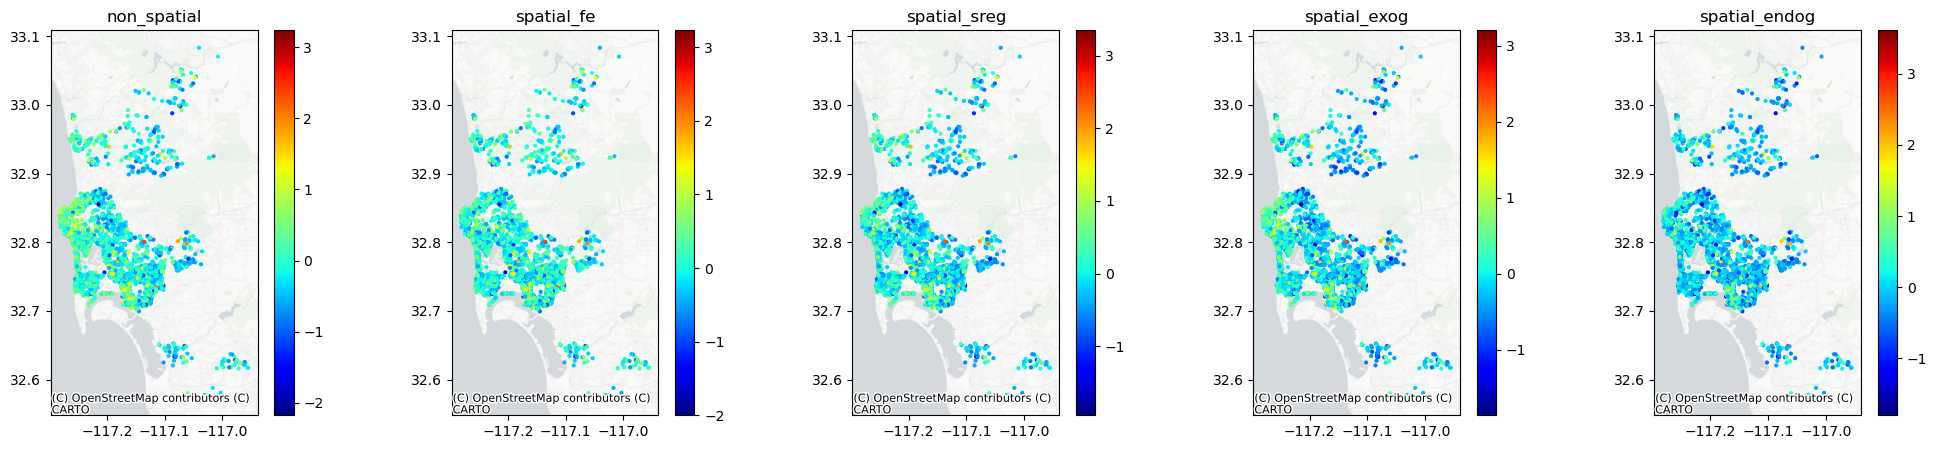

In [31]:
#Mapas de residuos para cada modelo
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(25,5))

for nm,m in enumerate(models.keys()):
    ax=fig.add_subplot(1,5,nm+1)
    df_res.plot(ax=ax,column='%s_res'%m,legend=True,markersize=4,cmap='jet')
    ctx.add_basemap(ax, crs=df_res.crs,source=ctx.providers.CartoDB.PositronNoLabels);
    ax.set_title(m);


non_spatial MSE: 0.2296876592326464
spatial_fe MSE: 0.20243528797012011
spatial_sreg MSE: 0.21928744800817876
spatial_exog MSE: 0.21595328406948333
spatial_endog MSE: 0.20272471194952468


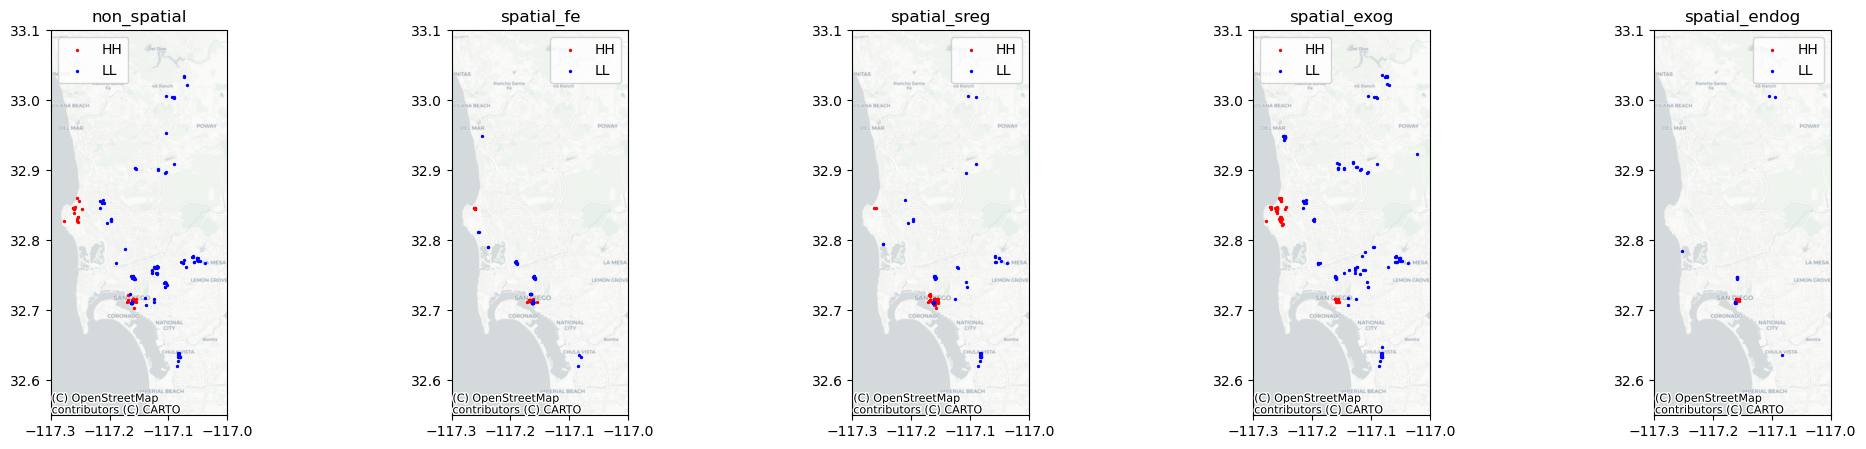

In [32]:
#También graficamos los hot spots y cold-spots de residuos para cada modelo
from sklearn.metrics import mean_squared_error as mse

fig=plt.figure(figsize=(25,5))

for nm,m in enumerate(models.keys()):
    ax=fig.add_subplot(1,5,nm+1)
    lisa=esda.moran.Moran_Local(df_res['%s_res'%m], w, permutations=999)
    plotLISA(df_res,lisa,ax)
    ax.set_title(m);
    model_mse=mse(df_res['log_price'],models[m].predy.flatten())
    print(m,'MSE:',model_mse)

plt.show()